In [105]:
%matplotlib inline

import sqlalchemy
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

from matplotlib import style
from datetime import date

style.use('fivethirtyeight')

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [4]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [5]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)


In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [7]:
# Collect the names of tables within the database
inspector.get_table_names()


['measurement', 'station']

In [8]:
# Measurement columns
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Station columns
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


In [67]:
# Calculate the date 1 year ago from the last data point in the database

# Latest date
today = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last day in the list of dates: {today[0]}")


Last day in the list of dates: 2017-08-23


In [68]:
# 1 year ago from today
today_datetime = date.fromisoformat(today[0])
one_year_ago = today_datetime - dt.timedelta(days=365)
one_year_ago


datetime.date(2016, 8, 23)

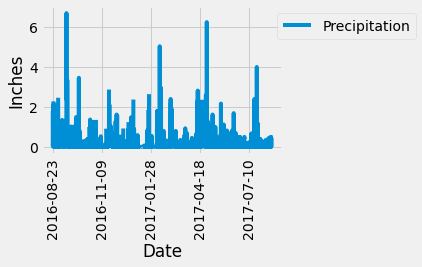

In [69]:
# Perform a query to retrieve the data and precipitation scores
precipitation_by_date_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_by_date_df = pd.DataFrame(precipitation_by_date_results, columns =['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_by_date_df = precipitation_by_date_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_by_date_df = precipitation_by_date_df.set_index('Date')

precipitation_by_date_df.plot()
plt.xticks(rotation='vertical')
plt.legend(loc='best', bbox_to_anchor=(.95, 1.0))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()


In [70]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_by_date_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [106]:
# Design a query to show how many stations are available in this dataset?
results = session.query(func.count(distinct(Station.station)))

for row in results:
    print(f"Number of stations: {row[0]}")


Number of stations: 9


In [115]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#engine.execute('SELECT station, count(*) station_count FROM measurement group by station order by station_count desc').fetchall()
stations_numbers = session.query(Measurement.station, func.count(Measurement.station).label("stations_count")).group_by(Measurement.station).order_by(desc("stations_count"))

first_one = True
most_active_station = ""
for row in stations_numbers:
    if first_one :
        most_active_station = row.station
        first_one = False
    print(f"Station name: {row.station} Station count: {row.stations_count}")


Station name: USC00519281 Station count: 2772
Station name: USC00519397 Station count: 2724
Station name: USC00513117 Station count: 2709
Station name: USC00519523 Station count: 2669
Station name: USC00516128 Station count: 2612
Station name: USC00514830 Station count: 2202
Station name: USC00511918 Station count: 1979
Station name: USC00517948 Station count: 1372
Station name: USC00518838 Station count: 511


In [124]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_temperature = session.query(func.max(Measurement.tobs).label("highest_temperature"), func.avg(Measurement.tobs).label("average_temperature"), func.min(Measurement.tobs).label("lowest_temperature")).filter(Measurement.station == most_active_station)

results = station_temperature.one()
highest_temperature = results.highest_temperature
lowest_temperature = results.lowest_temperature
average_temperature = results.average_temperature

print(f"Highest temperature for station {most_active_station}: {highest_temperature}")
print(f"Lowest temperature for station {most_active_station}: {lowest_temperature}")
print(f"Average temperature for station {most_active_station}: {average_temperature}")


Highest temperature for station USC00519281: 85.0
Lowest temperature for station USC00519281: 54.0
Average temperature for station USC00519281: 71.66378066378067


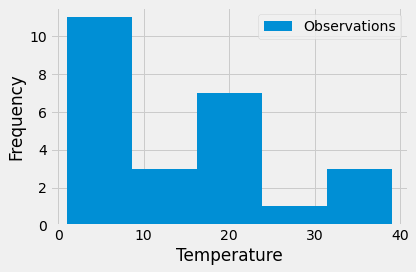

In [139]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_observations = session.query(Measurement.tobs, func.count(Measurement.tobs).label("observations")).filter(Measurement.date >= one_year_ago).filter(Measurement.station == most_active_station).group_by(Measurement.tobs).order_by(desc("observations"))

precipitation_by_date_df = pd.DataFrame(temperature_observations, columns =['Temperature', 'Observations'])
precipitation_by_date_df = precipitation_by_date_df.sort_values(by=['Observations'])
precipitation_by_date_df = precipitation_by_date_df.set_index('Temperature')

precipitation_by_date_df.plot.hist(bins=5)
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
